In [1]:
SIZE = 128

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf


datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            validation_split = 0.2,
            # rotation_range = 30,
            # width_shift_range = 0.2,
            # height_shift_range = 0.2,
            # shear_range = 0.2,
            # zoom_range = 0.2,
            # fill_mode = 'nearest',
            )

train_gen = datagen.flow_from_directory(
    "Dataset/",
    target_size=(SIZE, SIZE),
    color_mode = 'grayscale',
    seed = 42,
    batch_size=32,
    shuffle=True,
    subset='training',
    class_mode="input",
)
val_gen = datagen.flow_from_directory(
    "Dataset/",
    target_size=(SIZE, SIZE),
    color_mode='grayscale',
    batch_size=32,
    shuffle=False,
    subset='validation',
    class_mode="input",
)

Found 162080 images belonging to 1 classes.
Found 40519 images belonging to 1 classes.


In [3]:
from tensorflow.keras import layers, regularizers
import tensorflow as tf
def encoder():
    inputs = layers.Input(shape=(SIZE, SIZE,1))
    x = layers.Conv2D(16, 3, activation="relu", padding = 'same')(inputs)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(32, 3, activation="relu", padding = 'same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation="relu", padding = 'same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, activation="relu", padding = 'same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(256, 3, activation="relu", padding = 'same')(x)
    x = layers.MaxPooling2D(2)(x)

    model = tf.keras.Model(inputs=inputs, outputs=x, name = "encoder")
    return model

def bottleneck():
    inputs = layers.Input(shape=(4,4,256))
    x = layers.Flatten()(inputs)
    x = layers.Dense(1500, activation="relu")(x)
    model = tf.keras.Model(inputs=inputs, outputs=x,name = "bottleneck")
    return model

def decoder():
    inputs = layers.Input(shape=(1500,))
    x = layers.Dense(4 * 4 * 256, activation="relu")(inputs)
    x = layers.Reshape((4, 4, 256))(x)  
    
    x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(1, 3, activation="sigmoid", strides=2, padding="same")(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=x, name = "decoder")
    return model

In [4]:
model = tf.keras.models.Sequential([
    encoder(),
    bottleneck(),
    decoder()
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        (None, 4, 4, 256)         392320    
                                                                 
 bottleneck (Functional)     (None, 1500)              6145500   
                                                                 
 decoder (Functional)        (None, 128, 128, 1)       6540161   
                                                                 
Total params: 13,077,981
Trainable params: 13,077,981
Non-trainable params: 0
_________________________________________________________________


In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_path = 'best_model.keras'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=0)
early_stopping = EarlyStopping(
    monitor='loss',
    patience=1,
    
    )
from tqdm.keras import TqdmCallback

In [7]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),loss = tf.keras.losses.MeanSquaredError())
model.fit(train_gen,validation_data = val_gen,steps_per_epoch = 50000//32,validation_steps=50000*0.2//32,epochs = 5,batch_size=32,callbacks = [TqdmCallback(verbose=1),checkpoint_callback,early_stopping],verbose = 0)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [8]:
model.save("model.h5")

1/1 [==============================] - 1s 1s/step


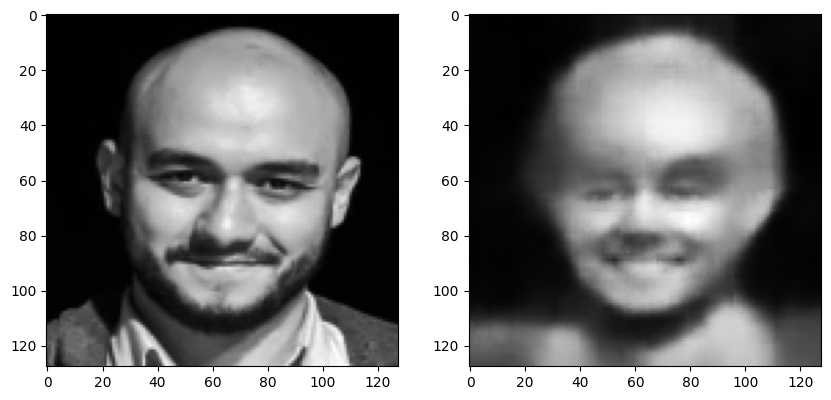

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))


img = cv2.imread("test.jpg",cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img,(128,128))


img = np.reshape(img,(1,128,128,1))
img = img/255
pred = model.predict(img)

plt.subplot(1, 2, 1)
plt.imshow(img[0], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(pred[0], cmap='gray')

In [10]:
layer_outputs = [layer.output for layer in model.layers if "conv" in layer.name]
visualization_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)
feature_maps = visualization_model.predict(img)

for layer_name, fmap in zip([layer.name for layer in model.layers if "conv" in layer.name], feature_maps):
    num_filters = fmap.shape[-1]
    size = fmap.shape[1]
    print(f"Layer: {layer_name}, Size: {size}x{size}, Filters: {num_filters}")
    fig, axes = plt.subplots(1, num_filters, figsize=(20, 5))
    for i in range(num_filters):
        ax = axes[i]
        ax.imshow(fmap[0, :, :, i], cmap='viridis')
        ax.axis('off')
    plt.suptitle(f"Outputs of {layer_name}")
    plt.show()

1/1 [==============================] - 0s 42ms/step
